# ガウス混合ピークでstanでの推定がコケたり、コケなかったり
ガウス混合分布ではなくて、ガウス形状の２つのピーク信号に正規ノイズが乗ったモデルの話です。  
gをガウス関数として、±uの位置にピークをもつものとして以下の式で示されるモデル関数ですね(xが時間軸,yが強度値)

Y= g(x+u)+0.3*g(x-u)+Noise*np.random.randn(N)

コレをstanで回帰します。

In [1]:
from stan_util import get_stan_model,print_code
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from numpy import exp
def sim(N,x,u,Noise):
    def g(x):
        return exp(-x**2)
    Y= g(x+u)+0.3*g(x-u)+Noise*np.random.randn(N)
    return Y
def plot(X,Y,fit,NOF_PLOT=200):
    print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy","yyN"]))))
    yy=fit.extract("yy")["yy"]
    yyN=fit.extract("yyN")["yyN"]
    A=fit.extract("A")["A"]
    skip=yy.shape[0]//NOF_PLOT
    if(skip<1):skip=1
    plt.title("Regression lines")
    plt.plot(X,yy[::skip,:].transpose(),color="blue",alpha=0.1)
    plt.plot(X,Y,color="red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    
    plt.title("Residue of Y")
    plt.xlabel("X")
    plt.ylabel("Y-yy")
    plt.plot(X,yy[::skip,:].transpose()-Y.reshape(-1,1),color="blue",alpha=0.1)
    plt.show()
    
    plt.title("each gauss peak")
    plt.plot(X,A[::skip,0]*yyN[::skip,0,:].transpose(),color="blue",alpha=0.1)
    plt.plot(X,A[::skip,1]*yyN[::skip,1,:].transpose(),color="red",alpha=0.1)
    plt.show()
    az.plot_trace(fit, var_names=("u","s","A"))
    plt.show()

model=get_stan_model("two_gauss")
print_code(model)
stan_data={
        "M":2,
        "u_u":(-1,1),
        "u_s":(1,1),
        "s_u":(1,1),
        "s_s":(1,1),
        "A_u":(1,0.6),
        "A_s":(1,0.6), 
        "T_beta":1.0,
        }



1 
2 functions{
3     vector gauss(vector x,real u,real s){
4         return exp(-square( (x-u)/s));
5     }
6 }
7 data{
8     int N;
9     int M;
10     vector[N] X;
11     vector[N] Y;
12     vector[M] u_u;
13     vector[M] u_s;
14     vector[M] s_u;
15     vector[M] s_s;
16     real sigma_s;
17     vector[M] A_u;
18     vector[M] A_s;
19     real T_beta;
20 }
21 
22 parameters{
23     real<lower=0> sigma;
24     vector<lower=0>[M] A;
25     ordered[M] u;
26     vector<lower=0>[M] s;
27 }
28 transformed parameters{
29     vector[N] yy;
30     vector[N] yyN[M];   
31     yy=rep_vector(0,N);
32     for( m in 1:M){
33         yyN[m] = gauss(X,u[m],s[m]);
34         yy+=A[m]* yyN[m];
35     }
36 }
37 
38 model{
39     u ~ normal(u_u,u_s);
40     s ~ normal(s_u,s_s);
41     A ~ normal(A_u,A_s);
42     sigma ~ normal(sigma_s,sigma_s);
43     target += T_beta*normal_lpdf(Y|yy,sigma);
44 }
45 


# コケない例
(わりとコケない。。。が、希にコケるchainもある）

Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.05  6.1e-5 4.4e-3   0.04   0.05   0.05   0.05   0.06   5145    1.0
u[1]   -0.99  6.1e-4   0.03  -1.06   -1.0  -0.98  -0.97  -0.93   2476   1.01
u[2]    0.99  3.3e-3   0.13   0.68   0.95   1.01   1.07   1.17   1577   1.02
s[1]    0.99  7.4e-4   0.04   0.91   0.97   0.99   1.02   1.07   2848   1.01
s[2]    0.88  3.9e-3   0.16   0.65   0.77   0.85   0.95   1.31   1723   1.01
A[1]    1.04  6.2e-4   0.03   0.98   1.02   1.04   1.05   1.08   2201   1.01
A[2]    0.28  3.5e-4   0.02   0.23   0.26   0.28   0.29   0.33   4820    1.0

Samples were drawn using NUTS at Sat Sep 26 23:02:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

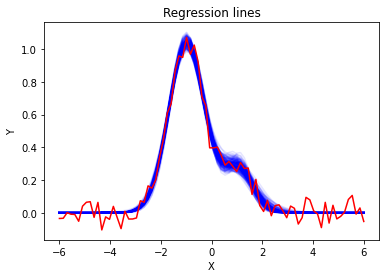

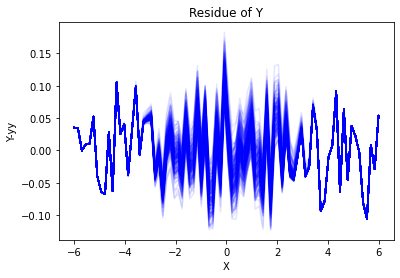

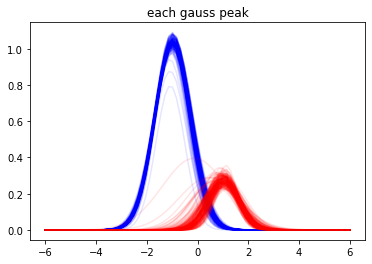

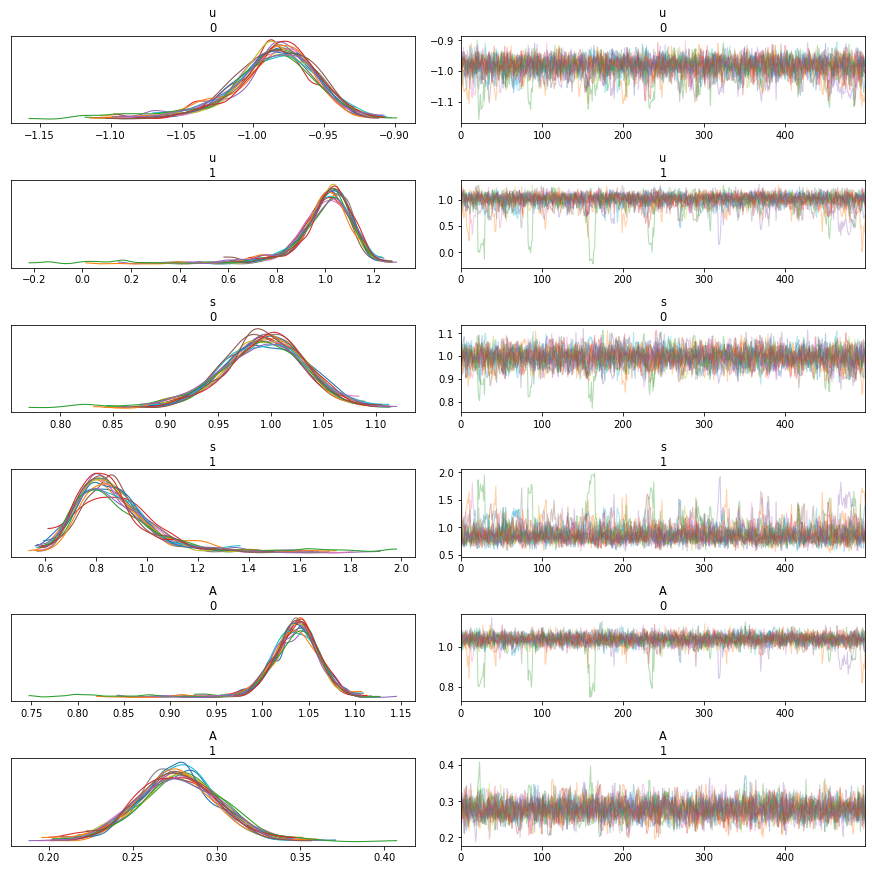

In [2]:
N=80
Noise=0.05
X=np.linspace(-6,6,N)
Y=sim(N,X,1,Noise=Noise)
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":1})
fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)
plot(X,Y,fit)



# ノイズを減らした場合
妙な局所解にはいってRhatが大きくなってしまいます。

Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma 3.7e-3  2.6e-3 7.3e-3 8.6e-4 9.5e-4 1.0e-3 1.1e-3   0.02      8  38.12
u[1]   -0.99    0.01   0.04   -1.0   -1.0   -1.0   -1.0  -0.88      8  10.32
u[2]    0.77    0.22   0.62  -0.89    1.0    1.0    1.0   1.01      8 150.99
s[1]    1.14    0.13   0.37    1.0    1.0    1.0    1.0   2.17      8  12.52
s[2]    0.97    0.02   0.06   0.79   0.99    1.0    1.0    1.0      8    5.3
A[1]    0.92    0.07    0.2   0.36    1.0    1.0    1.0    1.0      8  18.63
A[2]    0.34    0.04   0.11    0.3    0.3    0.3    0.3   0.65      8   9.63

Samples were drawn using NUTS at Sat Sep 26 23:03:07 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

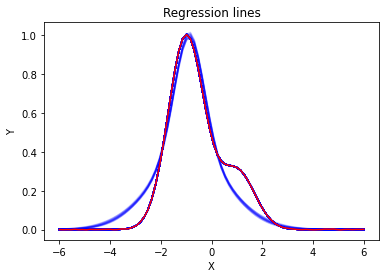

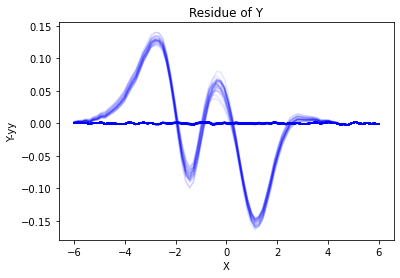

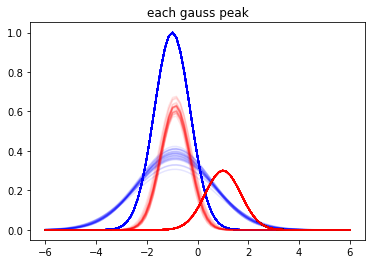

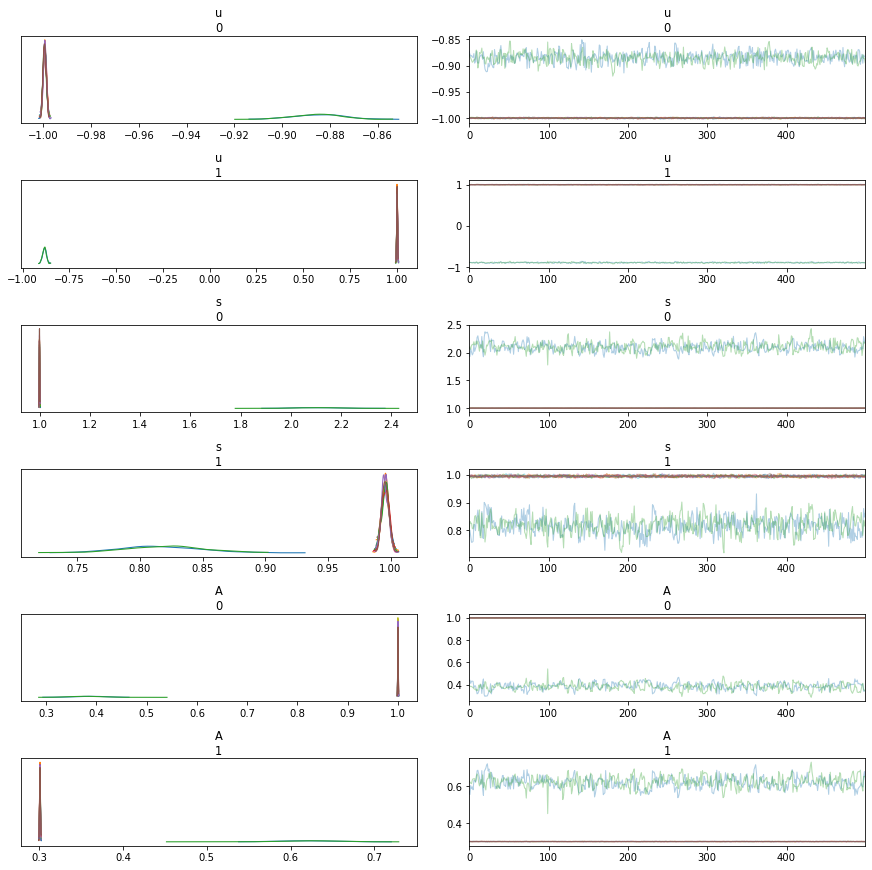

In [3]:
N=80
Noise=0.001 #ノイズを減らしてみた
X=np.linspace(-6,6,N)
Y=sim(N,X,1,Noise=Noise)
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":1})
fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)
plot(X,Y,fit)


# データ点数を増やした場合
やはり、妙な局所解にはいってRhatが大きくなってしまいます。

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.05  3.8e-3   0.01   0.05   0.05   0.05   0.05   0.08      8   9.15
u[1]   -0.99    0.01   0.04  -1.02  -1.01   -1.0   -1.0  -0.87      8   4.56
u[2]    0.77    0.22   0.63  -0.89   0.98    1.0   1.03   1.06      8   23.5
s[1]    1.14    0.13   0.38   0.98   0.99    1.0   1.01    2.2      8  12.25
s[2]    0.98    0.02   0.08   0.78   0.96    1.0   1.02   1.08     10   2.11
A[1]    0.92    0.07    0.2   0.37   0.99    1.0    1.0   1.01      8  16.67
A[2]    0.35    0.03    0.1   0.31   0.31   0.32   0.32   0.64      8    8.0

Samples were drawn using NUTS at Sat Sep 26 23:03:44 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

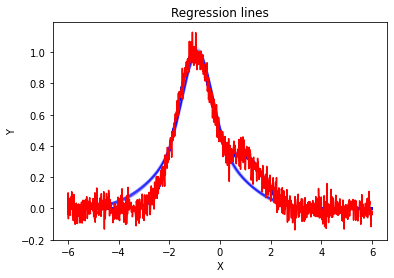

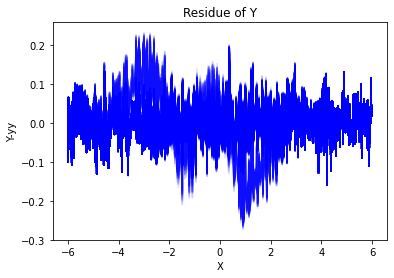

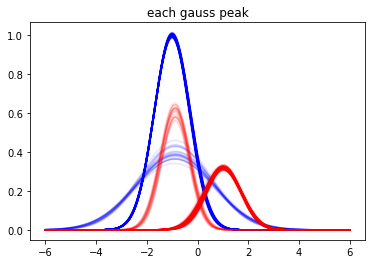

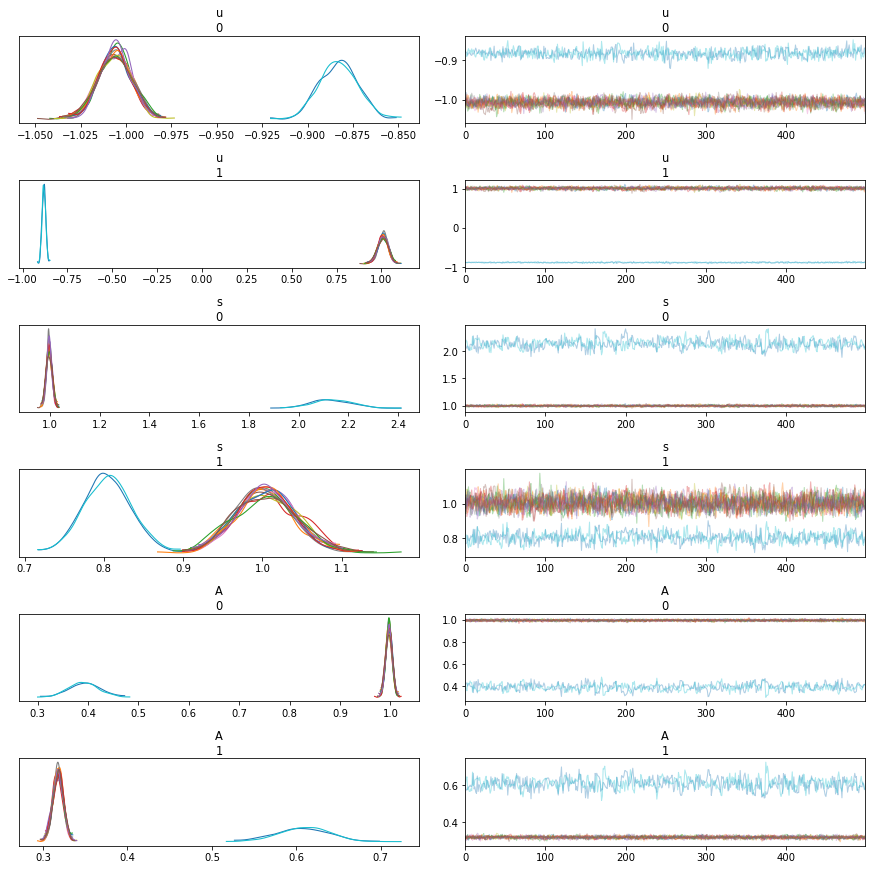

In [4]:
N=1000 #データ点数を増やしてみた
Noise=0.05 
X=np.linspace(-6,6,N)
Y=sim(N,X,1,Noise=Noise)
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":1})
fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)
plot(X,Y,fit)

# データを弄らずに対処する方法
いわゆる、焼き鈍しです。高温でやって次に通常温度でやるという2段階のみです。
## 焼き鈍し:ノイズを減らした場合での実験
逆温度を0.001にしています。

Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma 3.1e-3  1.6e-5 7.5e-4 1.7e-3 2.6e-3 3.1e-3 3.6e-3 4.7e-3   2110    1.0
u[1]   -1.03  1.6e-3   0.07  -1.17  -1.08  -1.03  -0.99  -0.91   1824   1.01
u[2]    0.76    0.01   0.38  -0.16   0.55   0.85   1.04   1.29   1208   1.01
s[1]    0.97  2.3e-3   0.09   0.77   0.91   0.97   1.03   1.15   1719   1.01
s[2]    1.26  9.7e-3   0.37   0.69   0.98    1.2   1.51   2.05   1427    1.0
A[1]    0.94  2.7e-3    0.1   0.68    0.9   0.96    1.0   1.07   1309   1.01
A[2]    0.31  1.3e-3   0.06    0.2   0.27   0.31   0.34   0.44   2064    1.0

Samples were drawn using NUTS at Sat Sep 26 23:03:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

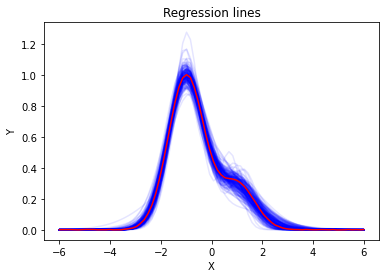

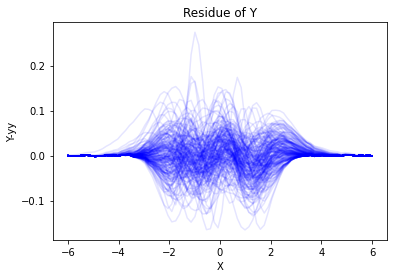

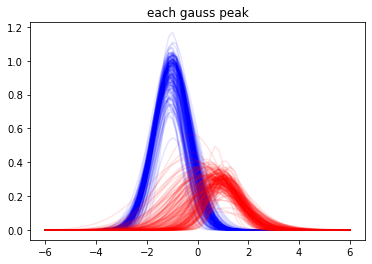

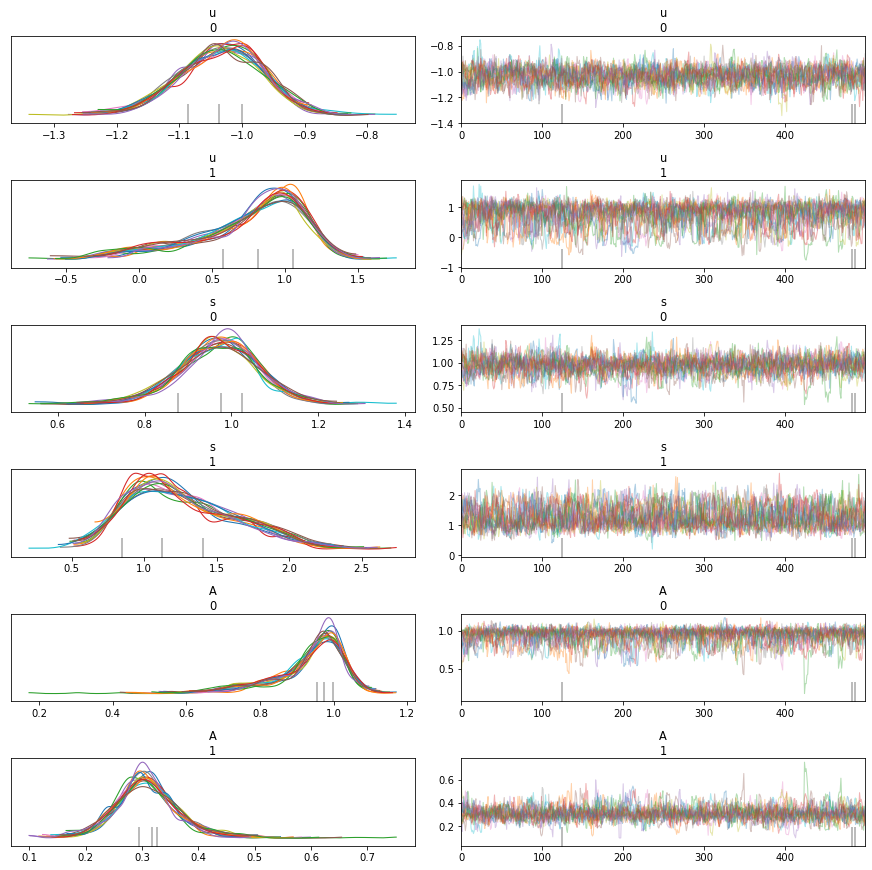

Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma 9.7e-4  1.7e-6 8.0e-5 8.3e-4 9.1e-4 9.7e-4 1.0e-3 1.1e-3   2243    1.0
u[1]    -1.0  1.0e-5 6.6e-4   -1.0   -1.0   -1.0   -1.0   -1.0   4183    1.0
u[2]     1.0  3.3e-5 2.2e-3   0.99    1.0    1.0    1.0    1.0   4351    1.0
s[1]     1.0  1.2e-5 8.4e-4    1.0    1.0    1.0    1.0    1.0   5069    1.0
s[2]     1.0  4.7e-5 2.8e-3   0.99    1.0    1.0    1.0   1.01   3574    1.0
A[1]     1.0  4.7e-6 4.3e-4    1.0    1.0    1.0    1.0    1.0   8592    1.0
A[2]     0.3  5.3e-6 4.3e-4    0.3    0.3    0.3    0.3    0.3   6565    1.0

Samples were drawn using NUTS at Sat Sep 26 23:04:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

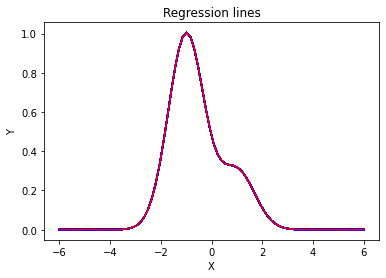

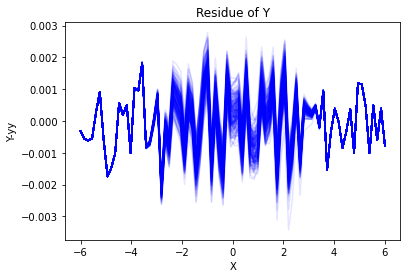

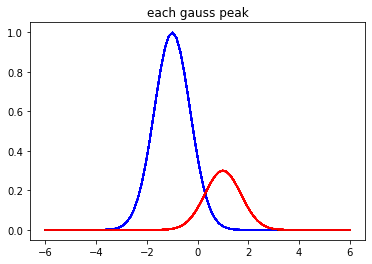

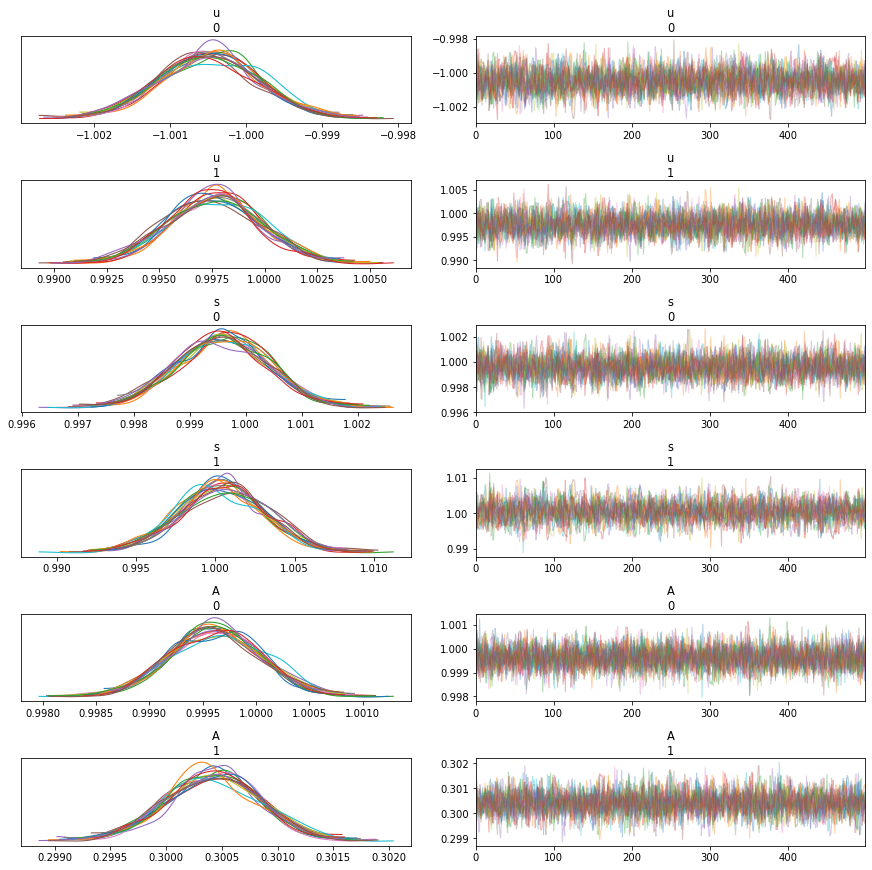

In [5]:
#温度をあげてみる。 @ ノイズを減らして旨くいかなかったもの
import pystan.misc
N=80
Noise=0.001
X=np.linspace(-6,6,N)
Y=sim(N,X,1,Noise=Noise)
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":0.001})
fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)
plot(X,Y,fit)
#温度をあげた結果の最後のサンプル位置を初期値にして、チェインを回し直してみる
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":1})
fit2=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16,init=fit.get_last_position())
plot(X,Y,fit2)


## 焼き鈍し:データ点数を増やした場合での実験
逆温度を0.1にしています。

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.05  5.5e-5 3.9e-3   0.04   0.05   0.05   0.05   0.06   5061    1.0
u[1]   -1.02  9.1e-4   0.04   -1.1  -1.04  -1.01  -0.99  -0.95   1563   1.01
u[2]    0.93  5.4e-3   0.16   0.53   0.86   0.96   1.04   1.16    904   1.02
s[1]    0.99  1.0e-3   0.04   0.91   0.97   0.99   1.02   1.07   1681   1.01
s[2]    1.09  5.2e-3   0.17   0.83   0.97   1.06   1.18   1.53   1117   1.01
A[1]    0.98  1.2e-3   0.04   0.89   0.97   0.99    1.0   1.03    908   1.02
A[2]    0.29  3.7e-4   0.02   0.25   0.28   0.29   0.31   0.34   3608    1.0

Samples were drawn using NUTS at Sat Sep 26 23:04:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

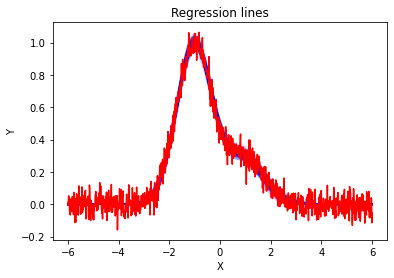

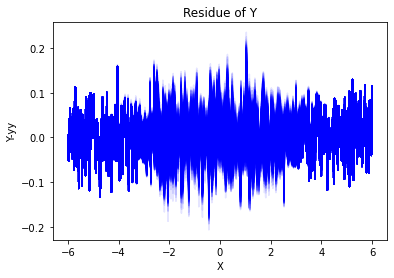

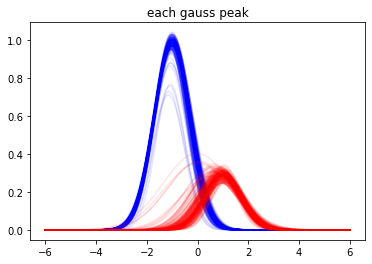

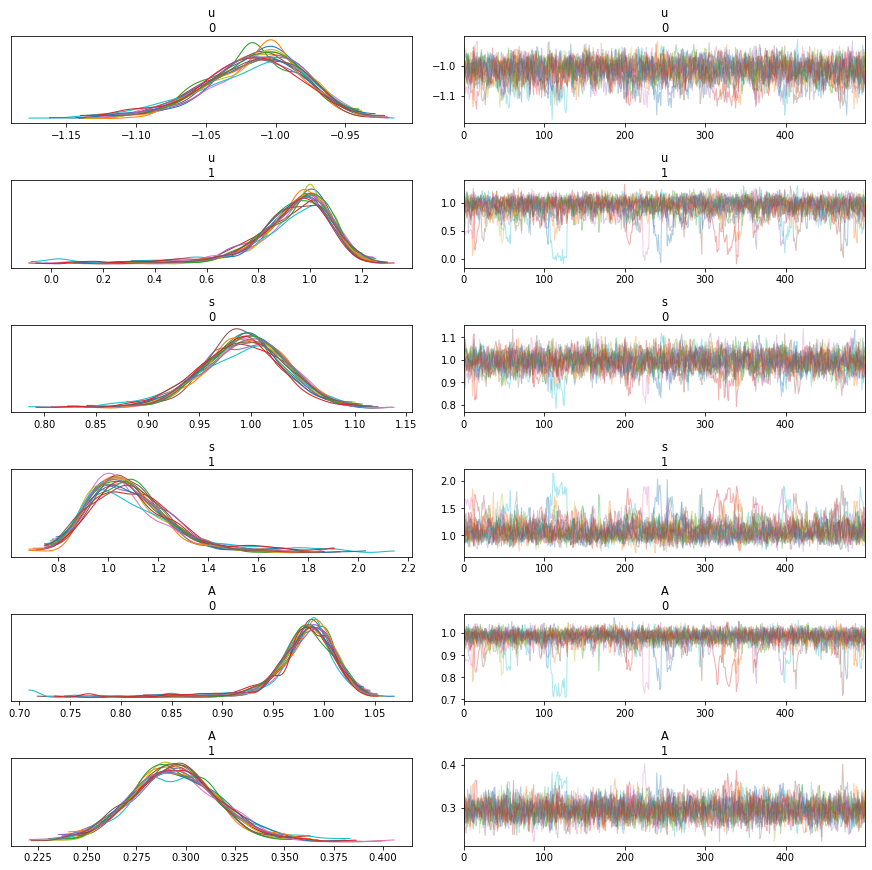

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: two_gauss_86072c304545eaf3612d57bf8b46a8a4.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.05  1.3e-5 1.1e-3   0.05   0.05   0.05   0.05   0.05   7247    1.0
u[1]    -1.0  1.5e-4 9.5e-3  -1.02  -1.01   -1.0   -1.0  -0.98   3936    1.0
u[2]    0.99  5.5e-4   0.03   0.92   0.97    1.0   1.02   1.06   3730    1.0
s[1]     1.0  1.9e-4   0.01   0.98   0.99    1.0   1.01   1.03   3928    1.0
s[2]    1.02  6.4e-4   0.04   0.94   0.99   1.02   1.04    1.1   3947    1.0
A[1]    0.99  7.5e-5 6.4e-3   0.98   0.99   0.99    1.0   1.01   7217    1.0
A[2]    0.29  8.0e-5 6.2e-3   0.28   0.29   0.29    0.3   0.31   5932    1.0

Samples were drawn using NUTS at Sat Sep 26 23:05:21 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

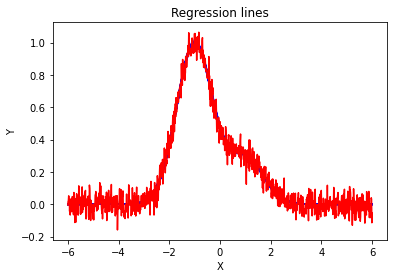

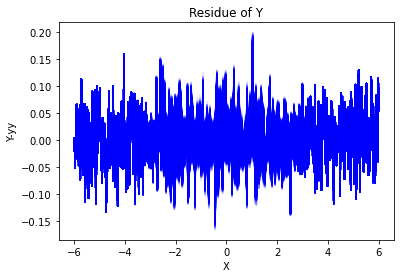

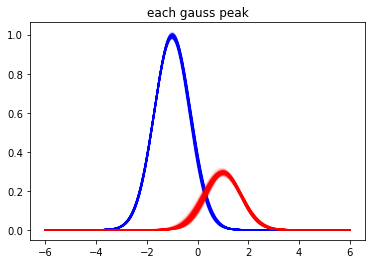

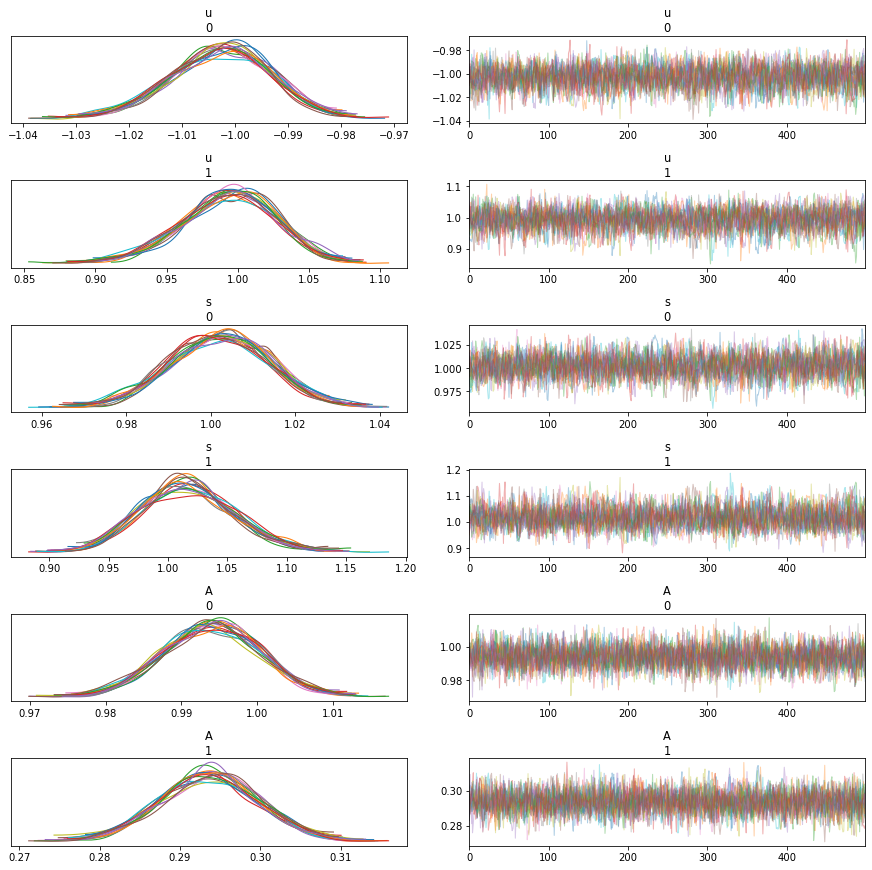

In [6]:
#温度をあげてみる。 @ データ点数を増やしてみて旨く行かなかったやつ
import pystan.misc
N=1000
Noise=0.05
X=np.linspace(-6,6,N)
Y=sim(N,X,1,Noise=Noise)
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":0.1})
fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)
plot(X,Y,fit)
#温度をあげた結果の最後のサンプル位置を初期値にして、チェインを回し直してみる
stan_data.update({"X":X,"Y":Y,"N":N, "sigma_s":Noise,"T_beta":1})
fit2=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16,init=fit.get_last_position())
plot(X,Y,fit2)